In [1]:
import numpy as np
import path as Path
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
from astropy.cosmology import FlatwCDM
from astropy.cosmology import FlatLambdaCDM
from astropy.cosmology import LambdaCDM
from astropy.cosmology import wCDM
from astropy.cosmology import Flatw0waCDM
import scipy
from escape_functions_noastropy import *
from multiprocessing import Process
from multiprocessing import Queue
from multiprocessing import Pool
import emcee
import corner

from multiprocessing import cpu_count

ncpu = cpu_count()
print("{0} CPUs".format(ncpu))

4 CPUs


In [2]:
def cosmology(cosmology):
    case = cosmology.name
    if case == 'Flatw0waCDM':
        return [cosmology.Om0, cosmology.w0, cosmology.wa, cosmology.h]
    
    elif case == 'FlatwCDM':
        return [cosmology.Om0, cosmology.w0, cosmology.h]

    elif case == 'wCDM':
        return [cosmology.Om0, cosmology.Ode0, cosmology.w0,cosmology.h]
        
    elif case == 'LambdaCDM':
        return [cosmology.Om0, cosmology.Ode0, cosmology.h]

    elif case == 'FlatLambdaCDM':
        return [cosmology.Om0, cosmology.h]

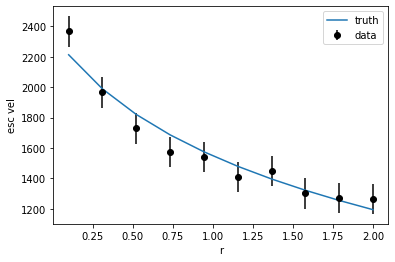

In [3]:
radial_bins = 10
error_kms = 100
cosmo = FlatLambdaCDM(H0=70, Om0=0.2,name = 'FlatLambdaCDM')
cosmo_params = cosmology(cosmo)
z = 0.2
M200_orig = 5e14 * u.solMass
M200, R200, conc, rho_s, sigma_rho_s, r_s, sigma_r_s =  nfws_errors(M200_orig, 0.8, z, cosmo_params, cosmo.name)
 
radius_array = np.linspace(0.1,2.0,radial_bins).round(3) #specify radius array for profiles. used in v_esc(r) funcs below.
xdata = radius_array / D_A(z, cosmo_params, cosmo.name).value
r,ydata = v_esc_NFW_M200(xdata,z,M200.value,100,cosmo_params, cosmo.name) + np.random.normal(0,error_kms,size=radial_bins) 
ydata_err = np.zeros(len(ydata)) + error_kms
r,truth = v_esc_NFW_M200(xdata,z,M200.value,100,cosmo_params, cosmo.name)

plt.plot(r, truth, label = 'truth')
plt.errorbar(r, ydata, yerr=ydata_err, fmt = "ko", label = "data")
plt.legend()
plt.xlabel("r")
plt.ylabel("esc vel")
plt.show()

In [4]:
def lnprior(theta):
    p_M200 = theta
    if not(1e13 < p_M200 < 1e17 ):
          return -np.inf
    return 0.0

def lnlike(theta, x, y, yerr): 
    p_theta_array = x
    p_z = 0.2
    p_M200 = theta[0]
    p_N = 100
    p_Omega_M = 0.2
    p_little_h = 0.7
    ymodel = v_esc_NFW_M200(p_theta_array,p_z,p_M200,p_N,[p_Omega_M,p_little_h],'FlatLambdaCDM')
    inv_sigma2 = 1.0/(yerr**2)
    return np.nan_to_num(-0.5*(np.sum((y-ymodel)**2*inv_sigma2)))

def lnprob(theta, x, y, yerr):
    lp = lnprior(theta)
    ll = lnlike(theta, x, y, yerr)
    if not np.isfinite(lp):
        return -np.inf
    if not np.isfinite(ll):
        return -np.inf    
    return lp + ll

c:\Backups\GitHub\Baysian Project\chrism71-escapevelocitycosmology-08c9bde138a7\escape_functions_noastropy.py:109: RuntimeWarning: invalid value encountered in double_scalars
  r200 =   (3*M200/(4*np.pi*200*rho_crit))**(1/3.0)
c:\Backups\GitHub\Baysian Project\chrism71-escapevelocitycosmology-08c9bde138a7\escape_functions_noastropy.py:280: RuntimeWarning: invalid value encountered in double_scalars
  c200 = A * (mass/Mpivot)**B * (1+redshift)**C
C:\Users\nsuse\Anaconda3\envs\env_full\lib\site-packages\astropy\units\quantity.py:466: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
c:\Backups\GitHub\Baysian Project\chrism71-escapevelocitycosmology-08c9bde138a7\escape_functions_noastropy.py:120: RuntimeWarning: invalid value encountered in sqrt
  v_esc = (-2.*phi_nfw(r,rho_s,r_s) +2*phi_nfw(req,rho_s,r_s)-q_z*(H_z**2.)*(r**2 - req**2) )**0.5


(100, 1000, 1)


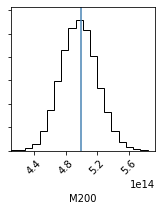

67
median(M200) =  496634363851041.8 +/- 22749309486096.938 22371316939435.438
median(logM200) =  14.696036766597018 +/- 0.01945152700001529 0.020017479490133994
Truth:  14.698970004336019


In [5]:
ndim, nwalkers, nsteps = 1, 100, 1000
p0 = np.transpose([np.random.uniform(1,10000,size=nwalkers)*1e13])

# pool = Pool(processes=4)     
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(xdata, ydata, ydata_err))
sampler.run_mcmc(p0, nsteps)

burn = 100
samples = sampler.chain[:, burn:, :].reshape((-1, 1))
print (np.shape(sampler.chain))
fig = corner.corner(samples[:,:], labels=["M200"], truths = [M200.value])
plt.show()
percentile_array = np.arange(33-16.5,67+16.5, 1.0)
print (len(percentile_array))
M200_fit =  np.percentile(sampler.chain[:,burn:,0],percentile_array)
M200_fit_50 =  np.percentile(sampler.chain[:,burn:,0],50)
M200_fit_33 =  np.percentile(sampler.chain[:,burn:,0],33-16.5)
M200_fit_67 =  np.percentile(sampler.chain[:,burn:,0],67+16.5)
print ('median(M200) = ', M200_fit_50, '+/-', M200_fit_67-M200_fit_50, M200_fit_50-M200_fit_33)
print ('median(logM200) = ', np.log10(M200_fit_50), '+/-', np.log10(M200_fit_67)-np.log10(M200_fit_50), np.log10(M200_fit_50) -np.log10(M200_fit_33))
sigma_M200_fit = (M200_fit_67-M200_fit_50 + M200_fit_50-M200_fit_33)/2.0
print ('Truth: ', np.log10(M200.value))

In [11]:
def lnprior(theta):
    p_rho_s = theta[0]
    p_r_s = theta[1]
    p_M200 = theta[2]
    if not((1e13 < p_rho_s < 1e17) & (0.2 < p_r_s < 1) & (p_M200 == 5e14)):
          return -np.inf
    return 0.0

def lnlike(theta, x, y, yerr): 
    p_theta_array = x
    p_z = 0.2
    p_M200 = theta[2]
    p_rho_s = theta[0]
    p_r_s = theta[1]
    p_N = 100
    p_Omega_M = 0.2
    p_little_h = 0.7
#    print p_theta_array,p_z,p_alpha,p_rho_2,p_r_2,p_Zv,p_Omega_M,p_little_h,p_w
    ymodel = v_esc_NFWs(p_theta_array,p_z,p_M200, p_rho_s, p_r_s,p_N,[p_Omega_M,p_little_h],'FlatLambdaCDM')
#    print model
    inv_sigma2 = 1.0/(yerr**2)
#    print -0.5*(np.sum((y-ymodel)**2*inv_sigma2))
    return np.nan_to_num(-0.5*(np.sum((y-ymodel)**2*inv_sigma2)))

def lnprob(theta, x, y, yerr):
    lp = lnprior(theta)
    ll = lnlike(theta, x, y, yerr)
    if not np.isfinite(lp):
        return -np.inf
    if not np.isfinite(ll):
        return -np.inf    
    return lp + lnlike(theta, x, y, yerr)

(100, 2000, 3)


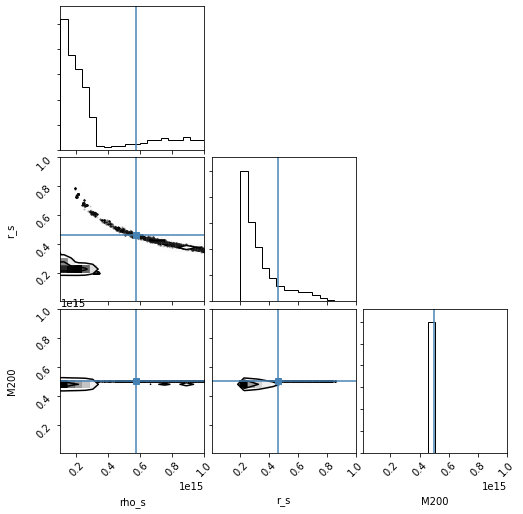

67
median(rho_s) =  109033153562087.89 +/- 1425989168560457.0 89249006254504.12
median(log rho_s) =  14.037558573351596 +/- 1.1485561219692038 0.7412412363432495
Truth:  14.759302927824459
median(r_s) =  0.28865272899419486 +/- 0.17751156238782212 0.06897011518184334
Truth:  0.46071067596929743


In [13]:
ndim, nwalkers, nsteps = 3, 100, 2000
p0 = np.transpose([np.random.uniform(1,10000,size=nwalkers)*1e13, np.random.uniform(0.2,1,size=nwalkers),np.random.uniform(1,1,size=nwalkers)*M200.value])#print np.shape(p0)

# pool = Pool(processes=35)     
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(xdata, ydata, ydata_err))
sampler.run_mcmc(p0, nsteps)

burn = 500
samples = sampler.chain[:, burn:, :].reshape((-1, 3))
print( np.shape(sampler.chain))
fig = corner.corner(samples[:,:], labels=["rho_s", "r_s", "M200"], truths = [rho_s, r_s, M200.value], range=[(1e14,1e15), (0.0,1.0), (1e13,1e15)])
plt.show()
percentile_array = np.arange(33-16.5,67+16.5, 1.0)
print (len(percentile_array))
rho_s_fit =  np.percentile(sampler.chain[:,burn:,0],percentile_array)
rho_s_fit_50 =  np.percentile(sampler.chain[:,burn:,0],50)
rho_s_fit_33 =  np.percentile(sampler.chain[:,burn:,0],33-16.5)
rho_s_fit_67 =  np.percentile(sampler.chain[:,burn:,0],67+16.5)
r_s_fit =  np.percentile(sampler.chain[:,burn:,1],percentile_array)
r_s_fit_50 =  np.percentile(sampler.chain[:,burn:,1],50)
r_s_fit_33 =  np.percentile(sampler.chain[:,burn:,1],33-16.5)
r_s_fit_67 =  np.percentile(sampler.chain[:,burn:,1],67+16.5)
print ('median(rho_s) = ', rho_s_fit_50, '+/-', rho_s_fit_67-rho_s_fit_50, rho_s_fit_50-rho_s_fit_33)
print ('median(log rho_s) = ', np.log10(rho_s_fit_50), '+/-', np.log10(rho_s_fit_67)-np.log10(rho_s_fit_50), np.log10(rho_s_fit_50) -np.log10(rho_s_fit_33))
sigma_rho_s_fit = (rho_s_fit_67-rho_s_fit_50 + rho_s_fit_50-rho_s_fit_33)/2.0
print ('Truth: ', np.log10(rho_s))
print ('median(r_s) = ', r_s_fit_50, '+/-', r_s_fit_67-r_s_fit_50, r_s_fit_50-r_s_fit_33)
sigma_rho_s_fit = (r_s_fit_67-r_s_fit_50 + r_s_fit_50-r_s_fit_33)/2.0
print ('Truth: ',r_s)

In [9]:
def lnprior(theta):
    p_rho_s = theta[0]
    p_r_s = theta[1]
    p_M200 = theta[2]
    if not((1e13 < p_rho_s < 1e17) & (0.2 < p_r_s < 1) & (1e13 < p_M200 < 1e17)):
          return -np.inf
    return 0.0

def lnlike(theta, x, y, yerr): 
    p_theta_array = x
    p_z = 0.2
    p_M200 = theta[2]
    p_rho_s = theta[0]
    p_r_s = theta[1]
    p_N = 100
    p_Omega_M = 0.2
    p_little_h = 0.7
#    print p_theta_array,p_z,p_alpha,p_rho_2,p_r_2,p_Zv,p_Omega_M,p_little_h,p_w
    ymodel = v_esc_NFWs(p_theta_array,p_z,p_M200, p_rho_s, p_r_s,p_N,[p_Omega_M,p_little_h],'FlatLambdaCDM')
#    print model
    inv_sigma2 = 1.0/(yerr**2)
#    print -0.5*(np.sum((y-ymodel)**2*inv_sigma2))
    return np.nan_to_num(-0.5*(np.sum((y-ymodel)**2*inv_sigma2)))

def lnprob(theta, x, y, yerr):
    lp = lnprior(theta)
    ll = lnlike(theta, x, y, yerr)
    if not np.isfinite(lp):
        return -np.inf
    if not np.isfinite(ll):
        return -np.inf    
    return lp + lnlike(theta, x, y, yerr)

(100, 2000, 3)


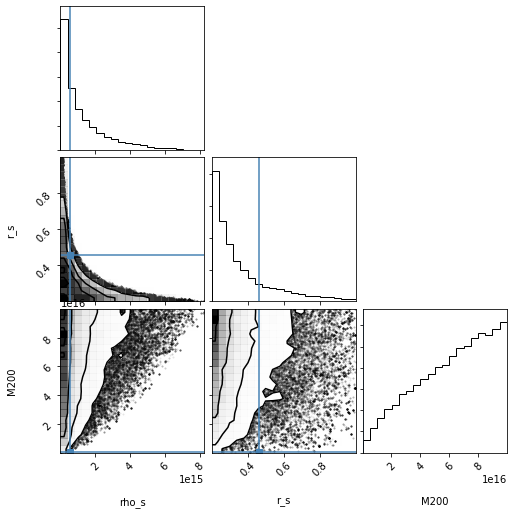

67
median(rho_s) =  754834540277075.2 +/- 1805186194359640.8 604422117863933.2
median(log rho_s) =  14.877851764715636 +/- 0.530391718135995 0.7005680590272334
Truth:  14.759302927824459
median(r_s) =  0.2976183330129347 +/- 0.22474885969599123 0.07584314860966512
Truth:  0.46071067596929743


In [10]:
ndim, nwalkers, nsteps = 3, 100, 2000
p0 = np.transpose([np.random.uniform(1,10000,size=nwalkers)*1e13, np.random.uniform(0.2,1,size=nwalkers),np.random.uniform(1,10000,size=nwalkers)*1e13])
# pool = Pool(processes=35)     
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(xdata, ydata, ydata_err))
sampler.run_mcmc(p0, nsteps)

burn = 500
samples = sampler.chain[:, burn:, :].reshape((-1, 3))
print( np.shape(sampler.chain))
fig = corner.corner(samples[:,:], labels=["rho_s", "r_s", "M200"], truths = [rho_s, r_s, M200.value])
plt.show()
percentile_array = np.arange(33-16.5,67+16.5, 1.0)
print (len(percentile_array))
rho_s_fit =  np.percentile(sampler.chain[:,burn:,0],percentile_array)
rho_s_fit_50 =  np.percentile(sampler.chain[:,burn:,0],50)
rho_s_fit_33 =  np.percentile(sampler.chain[:,burn:,0],33-16.5)
rho_s_fit_67 =  np.percentile(sampler.chain[:,burn:,0],67+16.5)
r_s_fit =  np.percentile(sampler.chain[:,burn:,1],percentile_array)
r_s_fit_50 =  np.percentile(sampler.chain[:,burn:,1],50)
r_s_fit_33 =  np.percentile(sampler.chain[:,burn:,1],33-16.5)
r_s_fit_67 =  np.percentile(sampler.chain[:,burn:,1],67+16.5)
print ('median(rho_s) = ', rho_s_fit_50, '+/-', rho_s_fit_67-rho_s_fit_50, rho_s_fit_50-rho_s_fit_33)
print( 'median(log rho_s) = ', np.log10(rho_s_fit_50), '+/-', np.log10(rho_s_fit_67)-np.log10(rho_s_fit_50), np.log10(rho_s_fit_50) -np.log10(rho_s_fit_33))
sigma_rho_s_fit = (rho_s_fit_67-rho_s_fit_50 + rho_s_fit_50-rho_s_fit_33)/2.0
print ('Truth: ', np.log10(rho_s))
print ('median(r_s) = ', r_s_fit_50, '+/-', r_s_fit_67-r_s_fit_50, r_s_fit_50-r_s_fit_33)
sigma_rho_s_fit = (r_s_fit_67-r_s_fit_50 + r_s_fit_50-r_s_fit_33)/2.0
print ('Truth: ',r_s)